# HomeWork #6

Завдання 1 <br>
У цьому завданні вам потрібно завантажити ось цей датасет. Тут ви знайдете 2 файли - з двовимірним датасетом та датасетом mnist. Для кожного з них застосуйте алгоритм K-means для кластеризації. Щоб знайти оптимальну кількість кластерів, скористайтесь ліктєвим методом.<br><br>
Завдання 2<br>
Візуалізуйте результат роботи кластеризації. Для випадку з mnist датасетом, вам потрібно ще скористатись алгоримтом PCA щоб зменшити розмірність ваших даних до 2-вимірного варіанту.<br>

In [178]:
from itertools import combinations
import math as m
from pathlib import Path
import pickle
import random
from typing import Union, Optional

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from kneed import KneeLocator
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import SVC
import tsfresh  # poetry add tsfresh
%matplotlib inline

## OBTAIN

In [11]:
def read_from_csvfile(file: Path) -> pd.DataFrame:
    """Read content from csv-file and return dataframe from content."""
    df = pd.read_csv(file, header=None)
    
    return df

In [12]:
dfs = [read_from_csvfile(item) for item in Path('data').iterdir() if item.is_file() and item.suffix.lower() in ('.csv',)]

In [16]:
data_2d, mnist = dfs[0], dfs[1]

In [51]:
data_2d.columns = ['y', 'c0', 'c1']

In [52]:
data_2d.head(3)

,y,c0,c1
0,0.0,-0.768716,0.460860
1,0.0,2.687848,2.366961
2,0.0,-0.201379,0.470430


In [50]:
mnist.shape, data_2d.shape

((500, 785), (200, 3))

## SCRUB

## EXPLORE

In [174]:
len(set(data_2d['y']))

2

In [187]:
data_2d['c0'][data_2d['y']==1]

100    3.983143
101    3.030008
102    2.621757
103    0.985955
104    0.094634
         ...   
195    0.629144
196   -0.723824
197    1.346107
198    3.608219
199    3.764228
Name: c0, Length: 100, dtype: float64

In [258]:

def draw_2D_many(df: pd.DataFrame, as_x: list, as_y: list, mark: Optional[str], title: str, xlabel: str, ylabel: str, figsize: tuple|None=None) -> None:
    size = figsize or (15, 5)
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1, 1, 1)
    major_ticks = np.arange(df[as_x].values.min(), df[as_x].values.max()+1, int((df[as_x].values.max() - df[as_x].values.min())/df.shape[0]) or 1)
    minor_ticks = np.arange(df[as_x].values.min(), df[as_x].values.max()+1, int((df[as_x].values.max() - df[as_x].values.min())/df.shape[0])/10 or 0.1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    major_ticks_y = np.arange(df[as_y].values.min(), df[as_y].values.max()+1, int((df[as_y].values.max() - df[as_y].values.min())/df.shape[0]) or 1)
    minor_ticks_y = np.arange(df[as_y].values.min(), df[as_y].values.max()+1, int((df[as_y].values.max() - df[as_y].values.min())/df.shape[0])/10 or 0.1)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)

    classes = set(df[mark]) if mark else ['1']
    for x, y in zip(as_x, as_y):
        [plt.scatter(
                    df[x][df[mark]==m] if mark else df[x], 
                    df[y][df[mark]==m] if mark else df[y], 
                    label=f'{mark}-{m}', 
                    color=random.choice('rgbcmyk'), 
                    marker=random.choice('o+xdvs*.^')
                    ) for m in range(len(classes))]

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    ax.grid(which='both')
    plt.show()

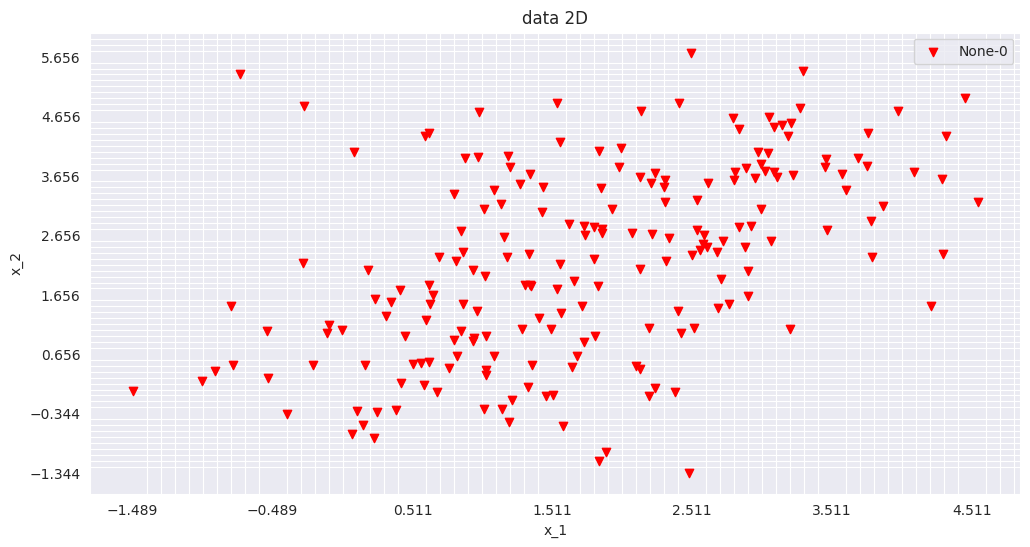

In [259]:
draw_2D_many(df=data_2d, as_x=['c0'], as_y=['c1'], mark=None, title=f'data 2D', xlabel='x_1', ylabel=f'x_2', figsize=(12, 6))

## MODEL

- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

##### Розрахуємо для розбиття на кластери від 1 до 11

In [260]:
X = data_2d[['c0', 'c1']].to_numpy()
x = [n_clus for n_clus in range(1, 12)]
kmeans = [KMeans(n_clusters=n_clus, random_state=0, n_init='auto').fit(X) for n_clus in x]

In [261]:
y = [km.inertia_ for km in kmeans]

In [137]:
def draw_2D(as_x: list, as_y: list, title: str, xlabel: str, ylabel: str, figsize: tuple|None=None) -> None:
    size = figsize or (15, 5)
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1, 1, 1)
    major_ticks = np.arange(min(as_x), max(as_x)+1, int((max(as_x) - min(as_x))/len(as_x)) or 1)
    minor_ticks = np.arange(min(as_x), max(as_x)+1, int((max(as_x) - min(as_x))/len(as_x)/10) or 0.1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    major_ticks_y = np.arange(min(as_y), max(as_y)+1, int((max(as_y) - min(as_y))/len(as_y)) or 1)
    minor_ticks_y = np.arange(min(as_y), max(as_y)+1, int((max(as_y) - min(as_y))/len(as_y)/10) or 0.1)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)


    plt.plot(
             as_x, 
             as_y, 
             label=f'2D', 
             color=random.choice('rgbcmyk'), 
             linestyle=random.choice(['-', '--', '-.', ':', None]),
             marker=random.choice('o+xdvs*.^')
             )

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    ax.grid(which='both')
    plt.show()

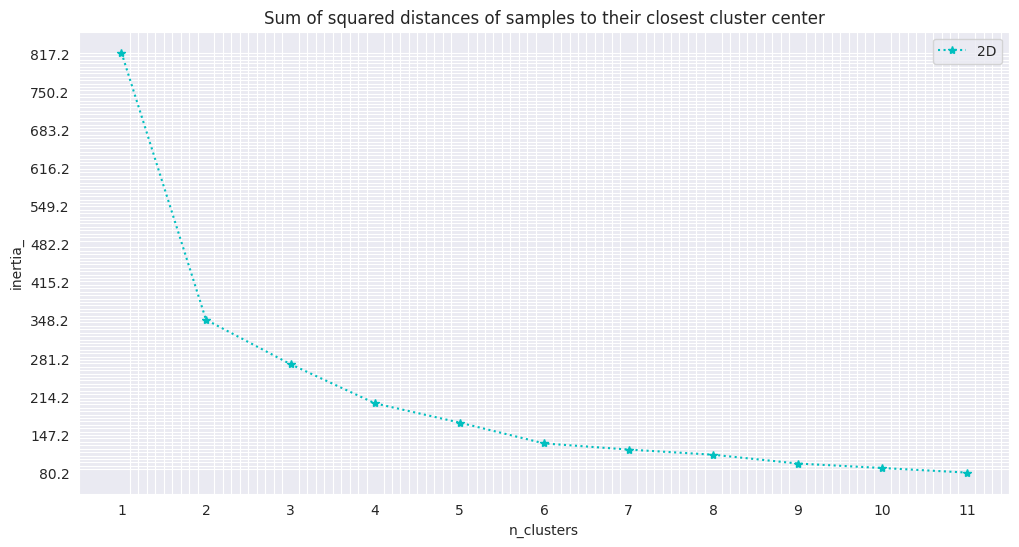

In [138]:
title = 'Sum of squared distances of samples to their closest cluster center'
draw_2D(as_x=x, as_y=y, title=title, xlabel='n_clusters', ylabel=f'inertia_', figsize=(12, 6))

Візуально начебто 2 кластери оптимально, але ...

- https://stackoverflow.com/questions/51762514/find-the-elbow-point-on-an-optimization-curve-with-python
- https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python/13849249#13849249
- https://github.com/arvkevi/kneed

In [151]:
kneedle = KneeLocator(x, y, S=1.0, curve='convex', direction='decreasing')

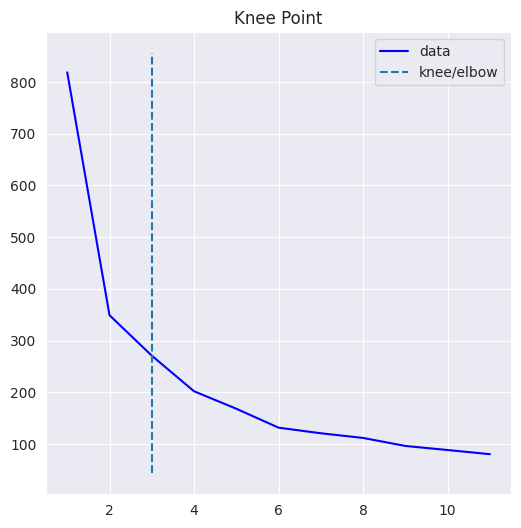

In [152]:
kneedle.plot_knee()

За алгоритмом оптимального значення: кластерів 3, зі значенням (суми) найбільших квадратичних відхилень від центроїдів 270.76

In [141]:
kneedle.knee, kneedle.knee_y

(3, 270.76301490918763)

Відносне зменшення значення найбільших квадратичних відхилень від центроїдів при покрокомому збільшенні кількості кластерів від 1

In [146]:
[(y[el-1]-y[el])/y[el-1] for el in range(len(y)) if el != 0]

[0.5737653082456686,
 0.22409806759241696,
 0.2544183671063387,
 0.16743506444255124,
 0.21781515371328095,
 0.08226000723630648,
 0.07506702535704787,
 0.13883175893527078,
 0.08200447518568296,
 0.09101620656036637]

In [158]:
kmeans[1:3]

[KMeans(n_clusters=2, n_init='auto', random_state=0),
 KMeans(n_clusters=3, n_init='auto', random_state=0)]

##### Якщо взяти з початкових даних перший стовпчик як результат кластеризації (відомий клас)

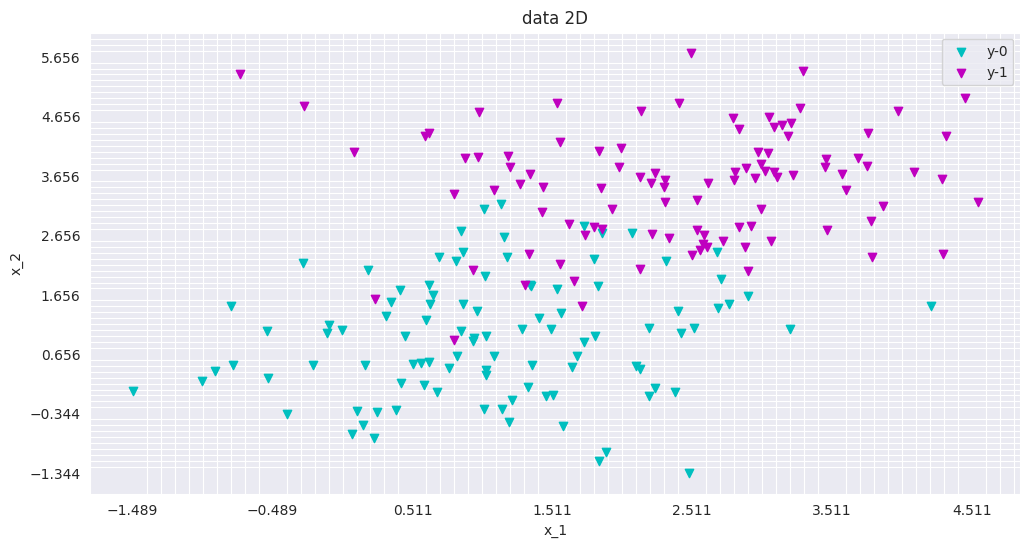

In [262]:
draw_2D_many(df=data_2d, as_x=['c0'], as_y=['c1'], mark='y', title=f'data 2D', xlabel='x_1', ylabel=f'x_2', figsize=(12, 6))

##### Якщо взяти з кластеризацію з розбиттям на 2 класи

In [246]:
kmeans[1].labels_

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0], dtype=int32)

In [247]:
kmeans[1].cluster_centers_

array([[2.46540572, 3.48660748],
       [0.97799508, 0.80217417]])

In [263]:
centroids = pd.DataFrame(kmeans[1].cluster_centers_)
centroids.columns = ['c0-2-x1', 'c0-2-x2']

In [264]:
centroids

,c0-2-x1,c0-2-x2
0,2.465406,3.486607
1,0.977995,0.802174


In [265]:
centroids.iloc[0]['c0-2-x1']

2.465405715770335

In [277]:
start = 0  # kmeans[1].labels_[0]
y2 = {'y2':kmeans[1].labels_}
y2['c0-2-x1'] = [centroids.iloc[0]['c0-2-x1'] if y2['y2'][i] == start else centroids.iloc[1]['c0-2-x1'] for i in range(len(y2['y2']))]
y2['c0-2-x2'] = [centroids.iloc[0]['c0-2-x2'] if y2['y2'][i] == start else centroids.iloc[1]['c0-2-x2'] for i in range(len(y2['y2']))]

In [278]:
y2 = pd.DataFrame(y2)
y2.head()

,y2,c0-2-x1,c0-2-x2
0,1,0.977995,0.802174
1,0,2.465406,3.486607
2,1,0.977995,0.802174
3,1,0.977995,0.802174
4,1,0.977995,0.802174


In [279]:
data_2d_c = pd.concat([data_2d, y2], axis=1)
data_2d_c.head(3)
data_2d_c = data_2d_c.sort_values(by=['y2'])
data_2d_c.head(3)

,y,c0,c1,y2,c0-2-x1,c0-2-x2
99,0.0,1.146001,3.182565,0,2.465406,3.486607
125,1.0,1.094621,3.404889,0,2.465406,3.486607
126,1.0,3.075717,2.548524,0,2.465406,3.486607


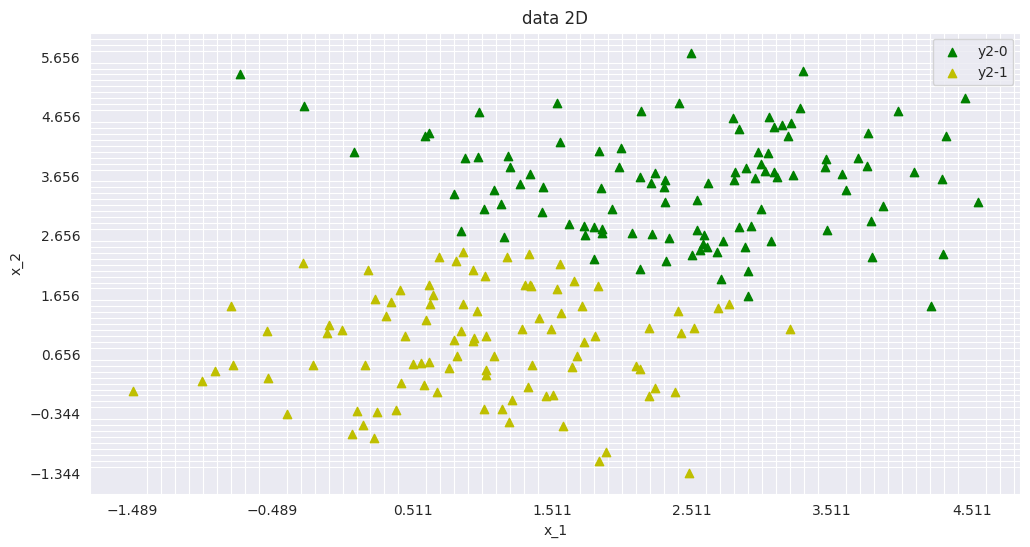

In [280]:
draw_2D_many(df=data_2d_c, as_x=['c0'], as_y=['c1'], mark='y2', title=f'data 2D', xlabel='x_1', ylabel=f'x_2', figsize=(12, 6))

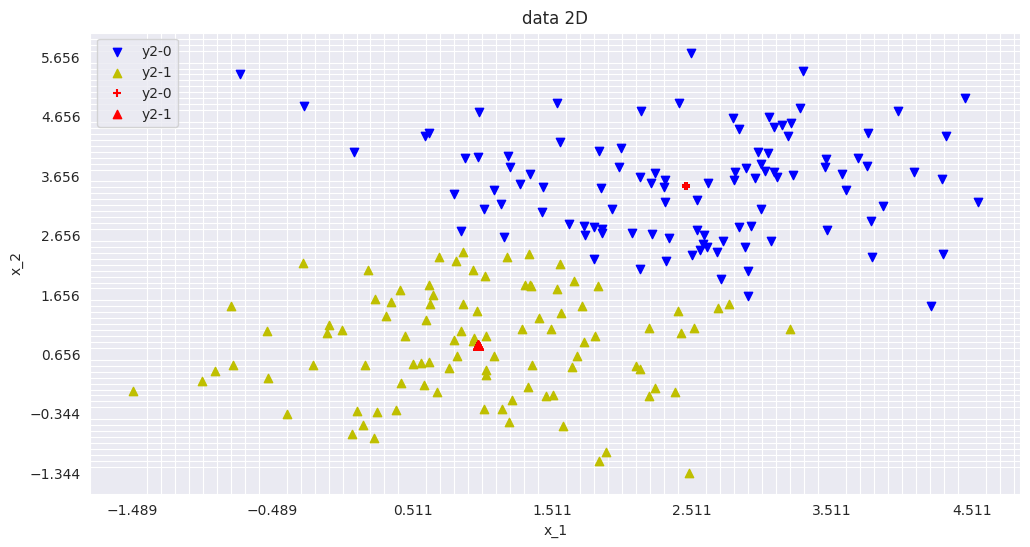

In [293]:
draw_2D_many(df=data_2d_c, as_x=['c0', 'c0-2-x1'], as_y=['c1', 'c0-2-x2'], mark='y2', title=f'data 2D', xlabel='x_1', ylabel=f'x_2', figsize=(12, 6))

##### Якщо взяти з кластеризацію з розбиттям на 3 класи

In [294]:
kmeans[2].labels_

array([1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2,
       0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 1, 0, 2, 0,
       2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0], dtype=int32)

In [295]:
kmeans[2].cluster_centers_

array([[2.67513782, 3.99328211],
       [0.74771856, 0.50438896],
       [1.96916569, 2.32414269]])

In [296]:
centroids = pd.DataFrame(kmeans[2].cluster_centers_)
centroids.columns = ['c0-3-x1', 'c0-3-x2']

In [297]:
centroids

,c0-3-x1,c0-3-x2
0,2.675138,3.993282
1,0.747719,0.504389
2,1.969166,2.324143


## INTERPRET

In [20]:
from sklearn.cluster import KMeans
import numpy as np

X = np.array([[1, 2], [1, 4], [1, 0],
              [10, 2], [10, 4], [10, 0]])

kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto').fit(X)

In [24]:
data_x = pd.DataFrame(X)

In [28]:
data_x.columns = ['c0', 'c1']

Відповідно labels_ - повертає список зі значеннями c(i)c^{(i)}c(i), а cluster_centers_ - це координати центроїдів.

In [21]:
kmeans.labels_

array([1, 1, 1, 0, 0, 0], dtype=int32)

In [31]:
kmeans.predict([[3, 2], [12, 3], [0, 0]])

array([1, 0, 1], dtype=int32)

In [32]:
kmeans.cluster_centers_

array([[10.,  2.],
       [ 1.,  2.]])

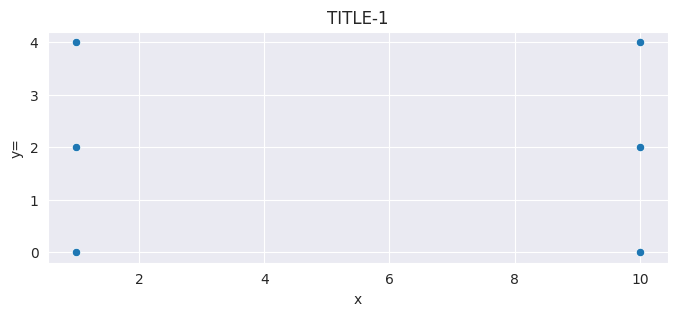

In [29]:
def draw_scatters_sns(df: pd.DataFrame, as_x: list, as_y: list, title: str) -> None:
    plt.figure(figsize=(8, 3))
    sns.set_style('darkgrid')
    [sns.scatterplot(x=x, y=y, data=df) for x, y in zip(as_x, as_y)]
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y=')
    plt.show()

draw_scatters_sns(data_x, as_x=['c0'], as_y=['c1'], title='TITLE-1')

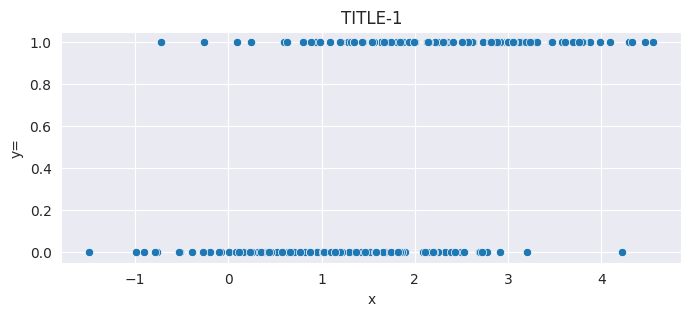

In [36]:
draw_scatters_sns(data_2d, as_x=['c0'], as_y=['y'], title='TITLE-1')